### Import

In [80]:
import tkinter as tk
from tkinter import ttk
from tkinter import font as tkFont  
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr 
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg,  NavigationToolbar2Tk)  
import mplcursors
import random
import pandas as pd
import pandastable
from pandastable import config
from pandastable import Table
import datetime
from datetime import date
from datetime import datetime
import seaborn as sns
import csv   
import numpy as np
import math as math
from functools import partial
from PIL import Image, ImageTk
import os.path as op
from fpdf import FPDF
import os


### Class DataManager
- Used to read the data from a datafile into a Pandas dataframe 
- Provides various functions that other classes may use to get hold of certain data

In [81]:
class DataManager:

    def __init__(self):
        self.df = None
        self.columns = None
        self.towns = None

    def calcPricePerYearOfLease(self, lease, resalePrice):
        fLease = 0
        if (len(lease) > 11):
            fLease = float(lease[0:2]) + (float(lease[9:11]) / 12)
        else:
            fLease = float(lease[0:2])

        return (resalePrice / fLease)

        
    def readData(self, filename):

        self.df = pd.read_csv(filename)
        self.columns = self.df.columns.tolist()
        self.towns = self.df.loc[:, 'town'].unique().tolist()

        self.flatTypes = self.df.loc[:, 'flat_type'].unique().tolist()
        self.date_list = self.df.loc[:, 'month'].unique().tolist()
        # As for the one ROOM flat it is wrongly positioned at index 5, so we relocate it.
        newindex = 0
        oldindex = 5
        self.flatTypes.insert(newindex, self.flatTypes.pop(oldindex))
        self.df["Price per Lease year"] = list(
            map(self.calcPricePerYearOfLease, self.df["remaining_lease"], self.df["resale_price"]))

    def getAveragePriceTown(self, town):
        dfTown = self.df[self.df.loc[:, 'town'] == town]
        noOfRows = len(dfTown)
        if noOfRows == 0:
            return 0
        total = dfTown.loc[:, 'resale_price'].sum()
        avPrice = total / noOfRows
        avPrice = int(round(avPrice, 0))
        return avPrice

    def getMinMaxPriceTownType(self, town, type):
        dfTown = self.df[(self.df.loc[:, 'town'] == town) & (self.df.loc[:, 'flat_type'] == type)]
        min = dfTown.loc[:, 'resale_price'].min()
        max = dfTown.loc[:, 'resale_price'].max()
        return min, max

    def getPricesTownType(self, town, type):
        dfTownType = self.df[(self.df.loc[:, 'town'] == town) & (self.df.loc[:, 'flat_type'] == type)]
        dfResalePrices = dfTownType.loc[:, 'resale_price']
        resalePrices = dfResalePrices.to_list()
        return resalePrices

    def getPricesTown(self, town):
        data = []
        for type in self.flatTypes:
            resalePrices = self.getPricesTownType(town, type)
            data.append(resalePrices)
        return data

    def getAvgPricesTownType(self, town, type):
        dfTownType = self.df[(self.df.loc[:, 'town'] == town) & (self.df.loc[:, 'flat_type'] == type)]
        if dfTownType.empty:
            avg_resale_prices = 0
        else:
            dfavgResalePrices = dfTownType.loc[:, 'resale_price'].mean()
            avg_resale_prices = int(round(dfavgResalePrices, 0))
        return avg_resale_prices

    def getAvgPricesTown(self, town):
        data = []
        for type in self.flatTypes:
            resalePrices = self.getAvgPricesTownType(town, type)
            data.append(resalePrices)
        return data


    def getTrxCountTownType(self, town, type):
        dfTownType = self.df[(self.df.loc[:, 'town'] == town) & (self.df.loc[:, 'flat_type'] == type)]
        return dfTownType.loc[:, 'resale_price'].count()

    def getTrxCountTown(self, town):
        data = []
        for type in self.flatTypes:
            count = self.getTrxCountTownType(town, type)
            data.append(count)
        return data

    def getFlatTypeAndTownByBudget(self, town, type, budgetMin, budgetMax, sdate):
        # some comment
        if (town == 'ALL'):
            dfTown = self.df[(self.df.loc[:, 'flat_type'] == type) & (
                    self.df.loc[:, 'resale_price'] >= budgetMin) & (self.df.loc[:, 'resale_price'] <= budgetMax) &
                             ((self.df.loc[:, 'month'] >= date.strftime(sdate, '%Y-%m')) & (
                                     self.df.loc[:, 'month'] <= date.strftime(date.today(), '%Y-%m')))]
        else:
            dfTown = self.df[(self.df.loc[:, 'town'] == town) & (self.df.loc[:, 'flat_type'] == type) & (
                    self.df.loc[:, 'resale_price'] >= budgetMin) & (self.df.loc[:, 'resale_price'] <= budgetMax) &
                             ((self.df.loc[:, 'month'] >= date.strftime(sdate, '%Y-%m')) & (
                                     self.df.loc[:, 'month'] <= date.strftime(date.today(), '%Y-%m')))]

        dfTown2 = dfTown.sort_values(by='resale_price')
        dfTown2 = dfTown2.rename(columns={"month": "Date", "town": "Town", "flat_model": "Flat Model",
                                          "lease_commence_date": "Lease Commence", "block": "Block",
                                          "storey_range": "Floor", "floor_area_sqm": "Floor Area(sqm)",
                                          "resale_price": "Price", "street_name": "Street",
                                          "remaining_lease": "Remaining Lease(yrs)"})
        return dfTown2

    def getByTownByAndDate(self, town, sdate):
        # some comment
        if (town == 'ALL'):
            dfTown = self.df[((self.df.loc[:, 'month'] >= date.strftime(sdate, '%Y-%m')) & (
                    self.df.loc[:, 'month'] <= date.strftime(date.today(), '%Y-%m')))]
        else:
            dfTown = self.df[(self.df.loc[:, 'town'] == town) &
                             ((self.df.loc[:, 'month'] >= date.strftime(sdate, '%Y-%m')) & (
                                     self.df.loc[:, 'month'] <= date.strftime(date.today(), '%Y-%m')))]

        dfTown2 = dfTown.sort_values(by='month')
        dfTown2 = dfTown2.rename(columns={"month": "Date", "town": "Town", "flat_model": "Flat Model",
                                          "lease_commence_date": "Lease Commence", "block": "Block",
                                          "storey_range": "Floor", "floor_area_sqm": "Floor Area(sqm)",
                                          "resale_price": "Price", "street_name": "Street",
                                          "remaining_lease": "Remaining Lease(yrs)"})
        return dfTown2
    
    


### Class ScreenManager
- Is used to magage loading/unloading the various screens

In [82]:
class ScreenManager:

    def __init__(self, window, winWidth, winHeight, dataManager):
        self.screenManager = self

        # We need access to data
        self.dataManager = dataManager

        # Our application various screens
        self.startScreen = StartScreen(window, winWidth, winHeight, self.screenManager)
        self.menuScreen = MenuScreen(window, winWidth, winHeight, self.screenManager)
        self.byTownScreen = ByTownScreen(window, winWidth, winHeight, self.screenManager)
        self.byTownCanvas = ByTownCanvas(window, self.byTownScreen.midRightFrame,  # master
                                         winWidth, winHeight, self.screenManager)
        self.byBudgetScreen = ByBudgetScreen(window, winWidth, winHeight, self.screenManager)
        self.byBudgetCanvas = ByBudgetCanvas(window, self.byBudgetScreen.midRightFrame,  # master
                                             winWidth, winHeight, self.screenManager)
        self.byAvgFlatPriceCanvas = ByAvgFlatPriceCanvas(window, self.byTownScreen.midRightFrame,  # master
                                                         winWidth, winHeight, self.screenManager)
        self.byTransactionCanvas = ByTransactionCanvas(window, self.byTownScreen.midRightFrame, # master
                                            winWidth,winHeight, self.screenManager)
        self.byAvgFlatPriceByMonthByFlatTypeCanvas = ByAvgFlatPriceByMonthByFlatTypeCanvas(window,
                                                                                           self.byTownScreen.midRightFrame,
                                                                                           # master
                                                                                           winWidth, winHeight,
                                                                                           self.screenManager)

    def loadScreen(self, screen):
        if screen == 'START_SCREEN':
            self.startScreen.frame.grid(row=0, column=0, padx=0, pady=0)
        elif screen == 'MENU_SCREEN':
            self.menuScreen.frame.grid(row=0, column=0, padx=0, pady=0)
        elif screen == 'BY_TOWN_SCREEN':
            self.byTownScreen.load()
        elif screen == 'BY_BUDGET_SCREEN':
            self.byBudgetScreen.load()

    def unLoadScreen(self, screen):
        if screen == 'START_SCREEN':
            self.startScreen.frame.grid_forget()
        elif screen == 'MENU_SCREEN':
            self.menuScreen.frame.grid_forget()
        elif screen == 'BY_TOWN_SCREEN':
            self.byTownScreen.forget()
        elif screen == 'BY_BUDGET_SCREEN':
            self.byBudgetScreen.forget()


### Class StartScreen
- Simple start screen with a Start button

In [83]:
class StartScreen:

    def __init__(self, window, winWidth, winHeight, screenManager):

        # We need access to the ScreenManager
        self.screenManager = screenManager

        # Import the tcl file

        # Set the theme with the theme_use method

        # Set up a frame for our StartScreen
        # ttk.Style().theme_use('azure-dark')
        self.frame = tk.Frame(master=window,
                              width=winWidth,
                              height=winHeight,
                              relief=tk.RAISED,
                              # background=bg_color,
                              #borderwidth=1
                              )
        #self.frame.pack(fill="both", expand=True)
        self.frame.grid_propagate(False)

        # self.frame.call('source', r'Azure-ttk-theme-main\azure-dark.tcl')
        style = ttk.Style(self.frame)
        style.theme_use("azure-dark")

        # Get ready all the widgets/items for this frame
        self.helv36 = tkFont.Font(family='Helvetica', size=18, weight=tkFont.BOLD)
        self.buttonFont = tkFont.Font(family='Open Sans', size=14)
        self.labelFont = tkFont.Font(family='Open Sans', size=14, weight=tkFont.BOLD)
        self.noticeFont = tkFont.Font(family='Open Sans', size=10, weight=tkFont.BOLD)
        self.powerFont = tkFont.Font(family='Open Sans', size=8, weight=tkFont.BOLD)
        self.pwErrorMsg = tk.Label(master=self.frame, fg='red', text="",
                                   font=self.noticeFont)
        self.pwErrorMsg1 = tk.Label(master=self.frame, fg='red', text="",
                                   font=self.noticeFont)

        screenTitleLabel = tk.Label(master=self.frame, text='Welcome to Resale Flat Prices Analyser', font=self.helv36)
        screenTitleLabel.place(x=200, y=50)

        # Setup a Entry field
        self.username = tk.StringVar()
        self.password = tk.StringVar()

        # uLabel = tk.Label(master=self.frame, text="Username:", font=self.labelFont)
        # uLabel.place(x=300 - 40, y=200)

        # pwLabel = tk.Label(master=self.frame, text="Password:", font=self.labelFont)
        # pwLabel.place(x=300 - 40, y=300)

        username_frame = ttk.LabelFrame(self.frame, text="Enter your Username", style='Card',
                                        padding=(10, 11, 12, 13))


        username_frame.grid(row=0, column=0, padx=350 - 40, pady=(120, 40), sticky="ew")

        self.uEntry = ttk.Entry(master=username_frame, width=45, textvariable=self.username)  # font = self.buttonFont
        self.uEntry.grid(row=0, column=0, padx=5, pady=(0, 0), sticky="ew")

        pwd_frame = ttk.LabelFrame(self.frame, text="Enter your Password", style='Card',
                                   padding=(10, 11, 12, 13))

        pwd_frame.grid(row=1, column=0, padx=350 - 40, sticky="ew")

        self.pwEntry = ttk.Entry(master=pwd_frame, textvariable=self.password, show="*", width=45)
        self.pwEntry.grid(row=1, column=0, sticky="ew")

        # self.uEntry.place(x=440 - 40, y=200, width=200, height=30) #440
        # self.pwEntry.place(x=440 - 40, y=300, width=200, height=30)

        self.uEntry.focus()
        # self.uEntry.insert(0, "admin")
        # self.pwEntry.insert(0, "admin")

        # Setup notice for new user
        notice = tk.Label(master=self.frame, text="*For new account please contact your administrator",
                          font=self.noticeFont)

        notice.grid(row=5, column=0, padx=150 - 40, pady=(55, 5), sticky="se")
        powered_label = tk.Label(master=self.frame, text="Powered by : Red Team",fg='yellow',
                          font=self.powerFont)

        powered_label.grid(row=6, column=0, padx=20, pady=(0, 10), sticky="sw")

        # Setup a Login Button and connect to a function (start)
        loginButton = ttk.Button(master=self.frame, text="Login", style='AccentButton', width=45,
                                 command=self.start)  # , font=self.buttonFont
        #loginButton.place(x=360 - 40, y=350)
        loginButton.grid(row=2, column=0, padx=360 - 40, pady=(40,5), sticky="s")
        self.username.set("admin")
        self.password.set("admin")
        self.userName = str()
        self.pw = str()

        # Setup Logo
        img = ImageTk.PhotoImage(Image.open("Redot.png").resize((100, 100)))
        imgLabel = tk.Label(master=self.frame, image=img)
        imgLabel.image = img
        imgLabel.place(anchor='nw')

    def start(self):
        loginData = []

        self.userName = self.uEntry.get()
        self.pw = self.pwEntry.get()

        with open('login.csv', 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                loginData.append(row)

            Col0 = [x[0] for x in loginData]
            Col1 = [x[1] for x in loginData]

            if self.userName in Col0:
                self.pwErrorMsg.config(text="")
                self.pwErrorMsg.place(x=400 - 40, y=350)
                for i in range(1, len(Col0)):
                    if Col0[i] == self.userName and Col1[i] == self.pw:
                        self.username.set("")
                        self.password.set("")
                        self.userName = str()
                        self.pw = str()
                        self.screenManager.unLoadScreen('START_SCREEN')
                        self.screenManager.loadScreen('MENU_SCREEN')
                        break

                    elif self.pw == "":
                        self.pwErrorMsg.config(text="Password should not be empty")
                        #self.pwErrorMsg.place(x=400 - 40, y=400)
                        self.pwErrorMsg.grid(row=3, column=0, padx=350 - 40, pady=(5, 2), sticky="s")
                        break

                    else:
                        self.pwErrorMsg.config(text="Username and Password does not match.")
                        self.pwErrorMsg1.config(text="Please contact your "
                                                    "administrator")
                        self.pwErrorMsg.grid(row=3, column=0, padx=350 - 40, pady=(5, 2), sticky="s")
                        self.pwErrorMsg1.grid(row=4, column=0, padx=350 - 40, pady=(5,2), sticky="s")
                        break
            else:
                self.pwErrorMsg.config(text="Username not found. Please contact your administrator")
                #self.pwErrorMsg.place(x=300 - 40, y=400)
                self.pwErrorMsg.grid(row=3, column=0, padx=350 - 40, pady=(5, 2), sticky="s")


### Class MenuScreen
- Screen with Menu to help us navigate to various Screens

In [84]:
class MenuScreen:

    def __init__(self, window, winWidth, winHeight, screenManager):
        # We need access to the ScreenManager and Window
        self.screenManager = screenManager
        self.window = window
        self.fontMenuTitle = tkFont.Font(family='Helvetica', size=24, weight=tkFont.BOLD)
        self.font15 = tkFont.Font(family='Helvetica', size=15, weight=tkFont.BOLD)

        # Setting a frame for our screen
        self.frame = tk.Frame(master=window,
                              width=winWidth,
                              height=winHeight,
                              relief=tk.RAISED,
                              # background='white',
                              #borderwidth=1
                              )

        #self.frame.pack(fill="both", expand=True)
        self.frame.grid_propagate(False)

        style = ttk.Style(self.frame)

        # self.frame.tk.call("source","azure.tcl")
        style.theme_use("azure-dark")
        self.button_frame = ttk.LabelFrame(master=self.frame, text="Menu" ,style='Card', padding=(22, 23, 24, 25))

        self.button_frame.grid(row=0, column=0,padx=350 - 40, pady=(120, 120), sticky="nsew")
        self.button_frame.columnconfigure(index=0, weight=1)
        self.button_frame.rowconfigure(index=0,weight=1)
        # Get ready all the widgets/items for this frame


        # menuTitleLabel = tk.Label(master=self.frame, text='Menu',
        #                         font=self.fontMenuTitle)
        # menuTitleLabel.place(x=400, y=140)

        # Some variables to control placement
        shiftLeft = 100
        menuItemGap = 60

        # Make and place the buttons on the frame
        optionOneButton = ttk.Button(master=self.button_frame, text="By Town", style='AccentButton',
                                     command=self.optionOne, width=35)  # font=self.font15, height=1, width=15
        optionOneButton.grid(row=0, column=0, padx=5, pady=15, sticky="ew")

        # optionOneButton.place(x=450 - shiftLeft, y=200)

        optionTwoButton = ttk.Button(master=self.button_frame, text="By Budget", style='AccentButton', width=35,
                                     command=self.optionTwo)
        optionTwoButton.grid(row=1, column=0, padx=5, pady=15, sticky="ew")
        # optionTwoButton.place(x=450 - shiftLeft, y=200 + menuItemGap)

        optionThreeButton = ttk.Button(master=self.button_frame, text="Logout", style='AccentButton',width=35,
                                       command=self.exit)
        optionThreeButton.grid(row=2, column=0, padx=5, pady=15, sticky="ew")
        # optionThreeButton.place(x=450 - shiftLeft, y=200 + 2 * menuItemGap)

    def optionOne(self):
        self.screenManager.unLoadScreen('MENU_SCREEN')
        self.screenManager.loadScreen('BY_TOWN_SCREEN')

    def optionTwo(self):
        self.screenManager.unLoadScreen('MENU_SCREEN')
        self.screenManager.loadScreen('BY_BUDGET_SCREEN')

    def exit(self):
        self.screenManager.unLoadScreen('MENU_SCREEN')
        self.screenManager.loadScreen('START_SCREEN')

### ByTownScreen
- This Screen will allow the uses to diplay boxplots of flat sale prices per town
- Screen is ogranized with various sub frame:
    - The screen contains three main sub frames (topFrame,midFrame and bottomFrame)
    - The frame in the middle is then splitted further into two sub frames (midLeftFrame and midRightFrame)
    - The ByTownCanvas (to display the boxplot) is then placed in the midRightFrame frame


In [85]:
class ByTownScreen:

    def __init__(self, window, winWidth, winHeight, screenManager):
        # We need access to Window, DataManager and ScreenManager
        self.window = window
        self.screenManager = screenManager
        self.dataManager = self.screenManager.dataManager

        # Default, now adjustments needed
        self.winWidth = winWidth
        self.winHeight = winHeight

        # Adjust Screen (if needed  to enlarge/shrink as tkinter may meddle with resolution)
        # self.winWidth = (int) (winWidth *  1.5)
        # self.winHeight = (int) (winHeight * 1.5)

        # Various stuff we need to build our frames
        self.fontTitle = tkFont.Font(family='Helvetica', size=24, weight=tkFont.BOLD)
        self.font12 = tkFont.Font(family='Helvetica', size=12, weight=tkFont.BOLD)
        self.font_small = tkFont.Font(family='sans-serif', size=10, weight=tkFont.NORMAL)
        self.font8 = tkFont.Font(family = 'Helvetica', size = 8, weight = tkFont.BOLD)
        # Variable to control placement of widgest and frames
        self.TOP_FRAME_HEIGHT = 80
        self.BOTTOM_FRAME_HEIGHT = 50
        self.MID_FRAME_HEIGHT = self.winHeight - (self.TOP_FRAME_HEIGHT + self.BOTTOM_FRAME_HEIGHT)

        self.BACKGROUND_GREY = self.rgbTKinter(236, 236, 236)

        # Calculate width of graph frame as based on golden ratio
        goldenRatio = (1 + math.sqrt(7)) / 2
        self.GRAPH_DISPLAY_FRAME_WIDTH = round(goldenRatio * self.MID_FRAME_HEIGHT, 0)
        self.GRAPH_CONTROL_FRAME_WIDTH = self.winWidth - self.GRAPH_DISPLAY_FRAME_WIDTH
        # set legend Label
        # self.LegendLabel = tk.Label()
        self.button_clicked = 'box_plot_screen'
        # Our screen comprises three frames
        self.topFrame = self.createTopFrame()
        self.midFrame = self.createMidFrame()
        self.botFrame = self.createBotFrame()

        # Our mid frame comprises two frames
        self.midLeftFrame = self.createMidLeftFrame()
        self.midLeftFrame.grid(row=0, column=0, padx=0, pady=0)

        self.midRightFrame = self.createMidRightFrame()
        self.midRightFrame.grid(row=0, column=1, padx=0, pady=0)

    def backToMenu(self):
        self.screenManager.unLoadScreen('BY_TOWN_SCREEN')
        self.screenManager.loadScreen('MENU_SCREEN')

    def handleTownMenu(self, choice):
        if self.button_clicked == 'box_plot_screen':
            self.selectedTown = choice
            self.screenManager.byTownCanvas.plot()
            self.screenManager.byTownCanvas.fig.savefig('boxplot.png')
        elif self.button_clicked == 'bar_chart_screen':
            self.selectedTown = choice
            self.screenManager.byAvgFlatPriceCanvas.plot()
            self.screenManager.byAvgFlatPriceCanvas.fig.savefig('barchart.png')
        elif self.button_clicked == 'line_chart_screen':
            self.selectedTown = choice
            self.screenManager.byAvgFlatPriceByMonthByFlatTypeCanvas.plot()
            self.screenManager.byAvgFlatPriceByMonthByFlatTypeCanvas.fig.savefig('linechart.png')
        elif self.button_clicked == 'transaction_count_screen':
            self.selectedTown = choice
            self.screenManager.byTransactionCanvas.plot()
            self.screenManager.byTransactionCanvas.fig.savefig('transactionchart.png')
    def handleBoxPlotAllTransaction(self):
        self.button_clicked = 'box_plot_screen'
        self.screenManager.byTownCanvas.plot()
        self.screenManager.byTownCanvas.fig.savefig('boxplot.png')

    def handleAvgFlatPrices(self):
        self.button_clicked = 'bar_chart_screen'
        self.screenManager.byAvgFlatPriceCanvas.plot()
        self.screenManager.byAvgFlatPriceCanvas.fig.savefig('barchart.png')

    def handleAvgFlatPricesByMonth(self):
        self.button_clicked = 'line_chart_screen'
        self.screenManager.byAvgFlatPriceByMonthByFlatTypeCanvas.plot()
        self.screenManager.byAvgFlatPriceByMonthByFlatTypeCanvas.fig.savefig('linechart.png')
        
    def handleTransaction(self):
        self.button_clicked = 'transaction_count_screen'
        self.screenManager.byTransactionCanvas.plot()
        self.screenManager.byTransactionCanvas.fig.savefig('transactionchart.png')
        
    def exportpdf(self):
        today = datetime.now()
        today = today.strftime("%d/%m/%Y")
        pdf = FPDF()
        name = 'James'


        number = '81234567'
        WIDTH = 210
        HEIGHT = 297
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.image('Redot.png', WIDTH / 2 + 10, -20, WIDTH / 2)
        pdf.cell(10, 0, f'Agent Name: {name}', ln=True)
        pdf.cell(20, 20, f'Agent Number: {number}', ln=True)
        pdf.cell(10, 80, f'Report as of {today}:', ln=True)
        
        if op.isfile('linechart.png'):
            pdf.image('linechart.png', 5, 100, WIDTH / 2 - 5)
        else:
            pdf.image('na.png', 5, 100, WIDTH / 2 - 5,60)

        if op.isfile('barchart.png'):
            pdf.image('barchart.png', WIDTH / 2 + 5, 100, WIDTH / 2 - 5)
        else:
            pdf.image('na.png', WIDTH / 2 + 5, 100, WIDTH / 2 - 5,60)

        if op.isfile('Boxplot.png'):
            pdf.image('boxplot.png', 5, 180, WIDTH / 2 - 5)
        else:
            pdf.image('na.png', 5, 180, WIDTH / 2 - 5,60)

        if op.isfile('transactionchart.png'):
            pdf.image('transactionchart.png', WIDTH / 2 + 5, 180, WIDTH / 2 - 5)
        else:
            pdf.image('na.png', WIDTH / 2 + 5, 180, WIDTH / 2 - 5,60)
            
            
        today_date = datetime.now()
        today_date = str(today_date.strftime("%d%m%Y%H%M%S"))
        pdf.output('Redot'+'-'+today_date+'.pdf', 'f')
        if op.isfile('linechart.png'):
            os.remove('linechart.png')
        if op.isfile('barchart.png'):
            os.remove('barchart.png')
        if op.isfile('boxplot.png'):
            os.remove('boxplot.png')
        if op.isfile('transactionchart.png'):
            os.remove('transactionchart.png')

    def createTopFrame(self):
        topFrame = tk.Frame(master=self.window,
                            width=self.winWidth,
                            height=self.TOP_FRAME_HEIGHT,
                            relief=tk.RAISED,
                            #background=self.BACKGROUND_GREY,
                            #borderwidth=2
                            )
        style = ttk.Style(topFrame)
        style.theme_use("azure-dark")
        # Get ready all the widgets & items for this frame
        optionTitleLabel = tk.Label(master=topFrame, text='Resale Prices by Town',
                                    font=self.fontTitle)
        optionTitleLabel.place(x=280, y=10)

        # Create a drop down menu for selecting the town
        selectTownLabel = tk.Label(master=topFrame, font=self.font12,
                                   text="Select town:")
        stringVar = tk.StringVar()

        # The single star * unpacks the sequence/collectioninto positional arguments (starred expression)
        towns = self.screenManager.dataManager.towns
        stringVar.set(towns[0])  # Takes first Town in list
        self.selectedTown = towns[0]

        # Create the town selection drop down menu
        townMenu = ttk.OptionMenu(topFrame,
                                 stringVar, *towns, style='raised.TMenubutton',
                                 command=self.handleTownMenu)

        # Place it
        selectTownLabel.place(x=665, y=25)
        townMenu.place(x=765, y=20)

        return topFrame

    def createMidFrame(self):  # For Graph Display and Control
        midFrame = tk.Frame(master=self.window,
                            width=self.winWidth,
                            height=self.MID_FRAME_HEIGHT,
                            relief=tk.RAISED,
                            #background='white',
                            #borderwidth=1
                            )
        style = ttk.Style(midFrame)
        style.theme_use("azure-dark")
        return midFrame

    def createMidLeftFrame(self):
        midLeftFrame = tk.Frame(master=self.midFrame,
                                width=self.GRAPH_CONTROL_FRAME_WIDTH,
                                height=self.MID_FRAME_HEIGHT,
                                relief=tk.RAISED,
                                #background=self.BACKGROUND_GREY,
                                #borderwidth=1
                                )
        style = ttk.Style(midLeftFrame)
        style.theme_use("azure-dark")

        # Setting up a legend for out boxplot by using a label
        # legendText = "Flat types:\n----------------\n\n"
        # for i in range(len(self.dataManager.flatTypes)):
        #    legendText += str(i + 1) + ": " + self.dataManager.flatTypes[i] + "\n\n"

        # legendTextLabel = tk.Label(master=midLeftFrame, font=self.font12,
        #                          text=legendText, background=self.BACKGROUND_GREY, justify='left', anchor='w')

        # legendTextLabel.place(x=10, y=10)
        # return midLeftFrame
        # Left Panel Buttons
        # update 1

        #txtLabel = tk.Label(master=midLeftFrame, font=self.font12, text="Select graphs:").place(x=35, y=0)

        BoxplotOfAllTransaction = ttk.Button(master=midLeftFrame, text="Boxplot", style='ToggleButton', width=25,
                                             command=self.handleBoxPlotAllTransaction)

        BoxplotOfAllTransaction.place(x=30, y=40)

        AveragePriceByFlatType = ttk.Button(master=midLeftFrame, text="Bar Chart", style='ToggleButton', width=25,
                                            command=self.handleAvgFlatPrices)
        AveragePriceByFlatType.place(x=30, y=80)

        AveragePriceByFlatTypeByMonth = ttk.Button(master=midLeftFrame, text="Line Chart", style='ToggleButton', width=25,
                                                    command=self.handleAvgFlatPricesByMonth)
        AveragePriceByFlatTypeByMonth.place(x=30, y=120)

        NumberOfTransactions = ttk.Button(master=midLeftFrame, text="Transaction Count",
                                          style='ToggleButton', width=25, command=self.handleTransaction)
        NumberOfTransactions.place(x=30, y=160)

        ExportToPDF = ttk.Button(master=midLeftFrame, text="Export to PDF",
                                 style='ToggleButton', width=25, command=self.exportpdf)
        ExportToPDF.place(x=30, y=200)

        return midLeftFrame
    


    def createMidRightFrame(self):
        midRightFrame = tk.Frame(master=self.midFrame,
                                 width=self.GRAPH_DISPLAY_FRAME_WIDTH,
                                 height=self.MID_FRAME_HEIGHT,
                                 relief=tk.RAISED,
                                 background='white',
                                 borderwidth=1)

        return midRightFrame

    def createBotFrame(self):
        botFrame = tk.Frame(master=self.window,
                            width=self.winWidth,
                            height=self.BOTTOM_FRAME_HEIGHT,
                            relief=tk.RAISED,
                           # background=self.BACKGROUND_GREY,
                            borderwidth=2)
        style = ttk.Style(botFrame)
        style.theme_use("azure-dark")
        backToMenuButton = ttk.Button(master=botFrame, text="Back to menu",style='AccentButton',width=25,
                                     command=self.backToMenu)
        self.LegendLabel = tk.Label(master=botFrame, text="* 1R - 1 Room, 2R - 2 Rooms ... Exe-Executive,MG-Multi "
                                                          "Generation")
        # self.LegendLabel.config(text="* 1R - 1 Room, 2R - 2 Rooms ... Exe-Executive,MG-Multi Generation")
        self.LegendLabel.place(x=320, y=5)
        backToMenuButton.place(x=10, y=5)
        # return botFrame
        # update 2
        legendText = "Flat types: "
        for i in range( len(self.dataManager.flatTypes)):
            legendText+= " " + str(i+1)+" : " + self.dataManager.flatTypes[i]
            legendTextLabel = tk.Label(master=botFrame,font = self.font8 ,
            text=legendText, justify='left',anchor='w')
            legendTextLabel.place(x= 300,y=9)
        return botFrame

    def load(self):
        self.topFrame.grid(row=0, column=0, padx=0, pady=0)
        self.midFrame.grid(row=1, column=0, padx=0, pady=0)
        self.botFrame.grid(row=2, column=0, padx=0, pady=0)
        self.screenManager.byTownCanvas.plot()

    def forget(self):
        self.topFrame.grid_forget()
        self.midFrame.grid_forget()
        self.botFrame.grid_forget()

    def rgbTKinter(self, r, g, b):
        return f'#{r:02x}{g:02x}{b:02x}'

     

### Class ByTownCanvas
- Takes care of setting up a Canvas for data visualisation (in our to display the boxplot per town)
- The ByTownCanvas is placed in the midRightFrame frame of the ByTown screen

In [86]:
class ByTownCanvas:

    def __init__(self, window, master, winWidth, winHeight, screenManager):
        # We need access to Window, ScreenManager, DataManager
        self.window = window
        self.screenManager = screenManager
        self.dataManager = self.screenManager.dataManager
        self.master = master

        self.winWidth = winWidth
        self.winHeight = winHeight

        # Various stuff we need to build our frames
        self.fontTitle = tkFont.Font(family='Helvetica', size=24, weight=tkFont.BOLD)
        self.font12 = tkFont.Font(family='Helvetica', size=12, weight=tkFont.BOLD)

        # Get hold of figure and axis objects
        fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
        self.fig = fig
        self.ax = ax

        self.canvas = None

    def plotBoxplot(self, town):
        self.ax.clear()

        # Get the town that has been selected
        town = self.screenManager.byTownScreen.selectedTown

        # Get the data for the selected town  from our Data Manager
        data = self.dataManager.getPricesTown(town)
        xlabels = self.dataManager.flatTypes

        # Draw the box plot on the canvas
        self.ax.set_title(f'Boxplot for: {town}', fontsize=12, y=1.05)
        self.ax.set_yticks(np.arange(0, 1500000, 100000))
        self.ax.set_yticklabels(['100k', '200k', '300k', '400k', '500k', '600k', '700k', '800k', '900k'
                                    , '1000k', '1100k', '1200k', '1300k', '1400k', '1500k'], rotation=0)

        self.ax.boxplot(data)


    def plot(self):
        # Clear previous figure

        plt.cla()
        self.plotBoxplot(self.screenManager.byTownScreen.selectedTown)

        # Create canvas so as to display the Matplotlib figure
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.master)
        self.canvas.draw()

        # Placing the canvas on the Tkinter window
        xPlace = 15
        yPlace = 5
        self.canvas.get_tk_widget().place(x=xPlace, y=yPlace)
        self.screenManager.byTownCanvas.fig.savefig('boxplot.png')


In [87]:
class ByTransactionCanvas:

    def __init__(self, window, master, winWidth, winHeight, screenManager):
        # We need access to Window, ScreenManager, DataManager
        self.window = window
        self.screenManager = screenManager
        self.dataManager = self.screenManager.dataManager
        self.master = master

        self.winWidth = winWidth
        self.winHeight = winHeight

        # Various stuff we need to build our frames
        self.fontTitle = tkFont.Font(family='Helvetica', size=24, weight=tkFont.BOLD)
        self.font12 = tkFont.Font(family='Helvetica', size=12, weight=tkFont.BOLD)

        # Get hold of figure and axis objects
        fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
        self.fig = fig
        self.ax = ax
        #self.ax.tick_params(axis='both', labelsize=20)
        # sns.set_theme(context='notebook', style='whitegrid', palette='dark', font='sans-serif', color_codes=True,
        # rc=None)  # deep, muted, bright, pastel, dark, colorblind
        # sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        self.canvas = None

    def show_annotation(sel):
        yi = sel.target
        sel.annotation.set_text(f'{yi:.3f}')

    def autolabel(self,rects,data):
        for idx,rect in enumerate(rects):
            height = rect.get_height()
            self.ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,str(data[idx]),
                         ha='center', va='bottom', rotation=0,fontsize=8)

    def plot(self):
        # Clear previous figure
        #plt.cla()
        self.ax.clear()
      
        plt.rcParams["axes.spines.right"] = False
        plt.rcParams["axes.spines.top"] = False
        self.ax.grid(False)
        town = self.screenManager.byTownScreen.selectedTown
        data = self.dataManager.getTrxCountTown(town)
        ind = ['1', '2', '3', '4', '5', '6', '7']
        width = .5
        self.ax.set_title(f'Transaction Count for: {town}', fontsize=11, y=1.05)
        self.ax.set_yticks(np.arange(0, 5000, 250))
        self.ax.tick_params(axis='x', labelsize=8)
        self.ax.tick_params(axis='y', labelsize=8)

        self.ax.set_axisbelow(True)
        self.ax.grid(b=True, which='minor', axis='y', linewidth=0.07)  # minor,major,both

        self.ax.tick_params(top=False, right=False)

        self.ax.minorticks_on()

        for tick in self.ax.xaxis.get_minor_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)

        for tick in self.ax.yaxis.get_minor_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)

        bar_chart = self.ax.bar(ind, data, width, color='green')

        self.autolabel(bar_chart,data)        

        # ***************** Basic hovering - Yellow background **********
        # cursor = mplcursors.cursor(bar_chart, hover=True)
        # cursor.connect('add', show_annotation)
        # cursor = mplcursors.cursor(hover=mplcursors.HoverMode.Transient)

        # @cursor.connect("add")
        # def on_add(sel):
        #   x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
        #  sel.annotation.set(text=f"{height}",
        #                    position=(0, 20), anncoords="offset points")
        # sel.annotation.xy = (x + width / 2, y + height)
        # *****************************************************************

        # *******************Basic hovering without background ***********
        # Make the text pop up "underneath" the line and remove the box...
        # c1 = mplcursors.cursor(bar_chart, hover=True)

        # @c1.connect("add")
        # def _(sel):
        #    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
        #    sel.annotation.set(text=f"{height}", position=(0, 20), anncoords="offset points")
        #    # Note: Needs to be set separately due to matplotlib/matplotlib#8956.
        #    sel.annotation.set_bbox(None)
        # ***********************************************************************************

        # Make the box have a white background with a fancier connecting arrow
        c2 = mplcursors.cursor(bar_chart, hover=True)

        @c2.connect("add")
        def _(sel):
            x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
            sel.annotation.set(text=f"{height}")
            sel.annotation.get_bbox_patch().set(fc="white")
            # sel.annotation.set_bbox(None)
            sel.annotation.arrow_patch.set(arrowstyle="simple", fc="white", alpha=.5)

        # Create canvas so as to display the Matplotlib figure
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.master)
        self.canvas.draw()
        # Placing the canvas on the Tkinter window
        xPlace = 15
        yPlace = 5
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        self.canvas.get_tk_widget().place(x=xPlace, y=yPlace)
     #   self.screenManager.byAvgFlatPriceCanvas.fig.savefig('barchart.png')
        

In [88]:
class ByAvgFlatPriceByMonthByFlatTypeCanvas:

    def __init__(self, window, master, winWidth, winHeight, screenManager):
        # We need access to Window, ScreenManager, DataManager
        self.window = window
        self.screenManager = screenManager
        self.dataManager = self.screenManager.dataManager
        self.master = master

        self.winWidth = winWidth
        self.winHeight = winHeight

        # Various stuff we need to build our frames
        self.fontTitle = tkFont.Font(family='Helvetica', size=24, weight=tkFont.BOLD)
        self.font12 = tkFont.Font(family='Helvetica', size=12, weight=tkFont.BOLD)

        # Get hold of figure and axis objects
        fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
        self.fig = fig
        self.ax = ax
        self.ax.tick_params(axis='both', labelsize=20)
        self.canvas = None

    def plot(self):
        # Clear previous figure
        plt.cla()
        plt.rcParams["axes.spines.right"] = False
        plt.rcParams["axes.spines.top"] = False
        self.ax.grid(True)
        town = self.screenManager.byTownScreen.selectedTown
        sdate = date.today() - pd.DateOffset(months=12)
        dfTown = self.dataManager.getByTownByAndDate(town, sdate)
        self.ax.set_yticks(np.arange(0, 1500000, 100000))
        self.ax.set_yticklabels(
            ['0k', '100k', '200k', '300k', '400k', '500k', '600k', '700k', '800k', '900k', '1000k', '1100k', '1200k',
             '1300k',
             '1400k'], rotation=0, fontsize=9)
        sns.set_style("whitegrid")
        sns.color_palette("hls", 8)
        self.ax.set_axisbelow(True)
        self.ax.grid(b=True, which='minor', axis='y', linewidth=0.05)  # minor,major,both
        self.ax.tick_params(top=False, right=False)
        # self.ax.minorticks_on()

        # numpy array for chart plotting
        x = []
        y = []

        # get the months for the last one year
        for k, gp in dfTown.groupby(['Date']):
            x.append(k)

        # if (town != 'ALL'):
        self.ax.set_title(f'Avg. Prices By Flat Type for Past 1 Year: {town}', fontsize=11)
        # else:
        #    self.ax.set_title(f'Average Resale Prices By Flat Type for Last Year',fontsize=11)

        # retrieve data to plot the chart
        for key, grp in dfTown.groupby(['flat_type']):
            # iterate through the list and insert 0 if no corresponding data
            i = 0
            for key2, grp2 in grp.groupby(['Date']):
                while (x[i] != key2):
                    y.append(0)
                    i += 1

                y.append(grp2['Price'].mean())
                i += 1

            if (len(x) != len(y)):
                diffXY = len(x) - len(y)
                for index in range(diffXY):
                    y.append(0)

            lines = self.ax.plot(x, y, label=key)
            y.clear()

        plt.xticks(rotation=45, fontsize=9)
        self.fig.subplots_adjust(left=0.12, right=.9, bottom=0.16, top=0.9);
        self.ax.legend(fontsize="xx-small", bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.master)
        self.canvas.draw()
        # Placing the canvas on the Tkinter window
        xPlace = 0
        yPlace = 0
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        self.canvas.get_tk_widget().place(x=xPlace, y=yPlace)
        self.screenManager.byAvgFlatPriceByMonthByFlatTypeCanvas.fig.savefig('linechart.png')
        


In [89]:
class ByAvgFlatPriceCanvas:

    def __init__(self, window, master, winWidth, winHeight, screenManager):
        # We need access to Window, ScreenManager, DataManager
        self.window = window
        self.screenManager = screenManager
        self.dataManager = self.screenManager.dataManager
        self.master = master

        self.winWidth = winWidth
        self.winHeight = winHeight

        # Various stuff we need to build our frames
        self.fontTitle = tkFont.Font(family='Helvetica', size=24, weight=tkFont.BOLD)
        self.font12 = tkFont.Font(family='Helvetica', size=12, weight=tkFont.BOLD)

        # Get hold of figure and axis objects
        fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
        self.fig = fig
        self.ax = ax
        self.ax.tick_params(axis='both', labelsize=20)
        # sns.set_theme(context='notebook', style='whitegrid', palette='dark', font='sans-serif', color_codes=True,
        # rc=None)  # deep, muted, bright, pastel, dark, colorblind
        # sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        self.canvas = None

    def show_annotation(sel):
        yi = sel.target
        sel.annotation.set_text(f'{yi:.3f}')

    def plot(self):
        # Clear previous figure
        #plt.cla()
        self.ax.clear()
        plt.rcParams["axes.spines.right"] = False
        plt.rcParams["axes.spines.top"] = False
        self.ax.grid(False)
        town = self.screenManager.byTownScreen.selectedTown
        data = self.dataManager.getAvgPricesTown(town)
        ind = ['1', '2', '3', '4', '5', '6', '7']
        width = .5
        self.ax.set_title(f'Avg. Prices for Town: {town}', fontsize=11, y=1.05)
        self.ax.set_yticks(np.arange(0, 1600000, 100000))
        self.ax.set_yticklabels(
            ['0', '100k', '200k', '300k', '400k', '500k', '600k', '700k', '800k', '900k', '1000k', '1100k', '1200k', '1300k',
             '1400k', '1500k'], rotation=0)
        self.ax.tick_params(axis='x', labelsize=8)
        self.ax.tick_params(axis='y', labelsize=8)

        self.ax.set_axisbelow(True)
        self.ax.grid(b=True, which='minor', axis='y', linewidth=0.07)  # minor,major,both
        self.ax.tick_params(top=False, right=False)
        self.ax.minorticks_on()
        for tick in self.ax.xaxis.get_minor_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)

        for tick in self.ax.yaxis.get_minor_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)

        bar_chart = self.ax.bar(ind, data, width, color='#1520A6')

        # ***************** Basic hovering - Yellow background **********
        # cursor = mplcursors.cursor(bar_chart, hover=True)
        # cursor.connect('add', show_annotation)
        # cursor = mplcursors.cursor(hover=mplcursors.HoverMode.Transient)

        # @cursor.connect("add")
        # def on_add(sel):
        #   x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
        #  sel.annotation.set(text=f"{height}",
        #                    position=(0, 20), anncoords="offset points")
        # sel.annotation.xy = (x + width / 2, y + height)
        # *****************************************************************

        # *******************Basic hovering without background ***********
        # Make the text pop up "underneath" the line and remove the box...
        # c1 = mplcursors.cursor(bar_chart, hover=True)

        # @c1.connect("add")
        # def _(sel):
        #    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
        #    sel.annotation.set(text=f"{height}", position=(0, 20), anncoords="offset points")
        #    # Note: Needs to be set separately due to matplotlib/matplotlib#8956.
        #    sel.annotation.set_bbox(None)
        # ***********************************************************************************

        # Make the box have a white background with a fancier connecting arrow
        c2 = mplcursors.cursor(bar_chart, hover=True)

        @c2.connect("add")
        def _(sel):
            x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
            sel.annotation.set(text=f"{height}")
            sel.annotation.get_bbox_patch().set(fc="white")
            # sel.annotation.set_bbox(None)
            sel.annotation.arrow_patch.set(arrowstyle="simple", fc="white", alpha=.5)

        # Create canvas so as to display the Matplotlib figure
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.master)
        self.canvas.draw()

        # Placing the canvas on the Tkinter window
        xPlace = 15
        yPlace = 5
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        self.canvas.get_tk_widget().place(x=xPlace, y=yPlace)
        #self.screenManager.byTransactionCanvas.fig.savefig('transactionchart1.png')
        

 ### Class ByBudget
- A screen for Budget

In [90]:
class ByBudgetScreen:

    def __init__(self, window, winWidth, winHeight, screenManager):

        # We need access to Window, DataManager and ScreenManager
        self.window = window
        self.screenManager = screenManager
        self.dataManager = self.screenManager.dataManager

        # Default, now adjustments needed
        self.winWidth = winWidth
        self.winHeight = winHeight

        # Adjust Screen (if needed  to enlarge/shrink as tkinter may meddle with resolution)
        # self.winWidth = (int) (winWidth *  1.5)
        # self.winHeight = (int) (winHeight * 1.5)

        # Various stuff we need to build our frames
        self.fontTitle = tkFont.Font(family='Helvetica', size=24, weight=tkFont.BOLD)
        self.font12 = tkFont.Font(family='Corbel', size=11, weight=tkFont.NORMAL)
        self.font12_TNR = tkFont.Font(family='Lucida Console', size=12, weight=tkFont.BOLD)

        # Variable to control placement of widgest and frames
        self.TOP_FRAME_HEIGHT = 80
        self.BOTTOM_FRAME_HEIGHT = 50
        self.MID_FRAME_HEIGHT = self.winHeight - (self.TOP_FRAME_HEIGHT + self.BOTTOM_FRAME_HEIGHT)

        self.BACKGROUND_GREY = self.rgbTKinter(236, 236, 236)

        # Calculate width of graph frame as based on golden ratio
        goldenRatio = (1 + math.sqrt(5)) / 2
        self.GRAPH_DISPLAY_FRAME_WIDTH = round(goldenRatio * self.MID_FRAME_HEIGHT, 0)
        self.GRAPH_CONTROL_FRAME_WIDTH = self.winWidth - self.GRAPH_DISPLAY_FRAME_WIDTH

        # resale Date
        self.registration_date_text = tk.Label(font=self.font12,
                                               text="", background=self.BACKGROUND_GREY)
        self.total_records_text = tk.Label(font=self.font12,
                                           text="", background=self.BACKGROUND_GREY)
        self.resale_date = []
        self.resale_date_start = ""
        self.resale_date_end = ""
        self.total_records = ""

        # Our screen comprises three frames
        self.topFrame = self.createTopFrame()
        self.midFrame = self.createMidFrame()
        self.botFrame = self.createBotFrame()

        # Our mid frame comprises two frames
        self.midLeftFrame = self.createMidLeftFrame()
        self.midLeftFrame.grid(row=0, column=0, padx=0, pady=0)

        self.midRightFrame = self.createMidRightFrame()
        self.midRightFrame.grid(row=0, column=1, padx=0, pady=0)
        self.getFlatTypeAndTownByBudget()

        # styling Option menus
        #end = self.midLeftFrame
        #s = ttk.Style(end)
        #s.theme_use('clam')  # aqua,alt,default,classic,step,clam
        #s.configure('Emergency.TButton', borderwidth=1)  # Emergency.TButton, raised.TMenubutton

    def backToMenu(self):
        self.screenManager.unLoadScreen('BY_BUDGET_SCREEN')
        self.screenManager.loadScreen('MENU_SCREEN')


    def getFlatTypeAndTownByBudget(self):
        for widgets in self.midRightFrame.winfo_children():
            widgets.destroy()

        data = self.dataManager.getFlatTypeAndTownByBudget(self.selectedTown, self.selectedFlatType,
                                                           float(self.selectedMinBudget), float(self.selectedMaxBudget),
                                                           self.sdate)

        data = data.rename(columns={"Date": "Resale Registration Date", "town": "Town", "flat_model": "Flat Model",
                                    "Lease Commence": "Lease Commence Date", "block": "Block",
                                    "Floor": "Storey", "floor_area_sqm": "Floor Area(sqm)",
                                    "Price": "Resale Price", "Street": "Street Name",
                                    "Remaining Lease(yrs)": "Remaining Lease"})
        # data.sort_index(inplace=True, ascending=False,axis=0)
        root = self.midRightFrame
        self.total_records = str(len(data))
        # cm = sns.light_palette("green", as_cmap=True)
        if len(data) > 0:
            data_new = pd.DataFrame(data)
            # data_new.style.background_gradient(cmap=cm)
            # data_new.style.set_properties(**{'background-color':'black','color':'lawngreen'})
            data_new.drop(['flat_type'], axis=1, inplace=True)
            data_new['Resale Price']=data_new['Resale Price'].apply('${:,.0f}'.format)
            #data_new['Price per Lease year']=data_new['Price per Lease year'].apply('${:,.0f}'.format)
            self.resale_date = data_new.loc[:, 'Resale Registration Date'].sort_values(ascending=True)
            self.resale_date_start = self.resale_date.iloc[0]
            self.resale_date_end = self.resale_date.iloc[len(self.resale_date) - 1]

            self.registration_date_text.master = self.midLeftFrame
            self.registration_date_text.config(text=self.resale_date_start + " to " + self.resale_date_end)
            self.total_records_text.config(text=self.total_records)

            rearrange_columns = data_new[
                ['Block', 'Street Name', 'Storey', 'Floor Area(sqm)', 'Flat Model', 'Lease Commence Date',
                 'Remaining Lease',
                 'Resale Price', 'Resale Registration Date']]
            # rearrange_columns.set_index('Block',inplace=True)
            options = config.load_options()
            options = {'align': 'center',
                       'cellbackgr': '#ffffff', ##F4F4F3
                       'showindex': False,
                       'colheadercolor': '#626262',
                       'floatprecision': 2,
                       'font': 'cabin',
                       'fontsize': 11,
                       'fontstyle': '',
                       #'grid_color': '#ABB1AD',
                       'linewidth': 0.5,
                       'rowheight': 30,
                       'rowselectedcolor': '#ebebeb', # '#4a6984',
                       'textcolor': '#626262'
                       } #222

            #                      'rowheight': 22,
            #                       'cellwidth': 30,

            frame = tk.Frame(root)
            frame.pack(fill='both', expand=True)
            style = ttk.Style(frame)
            style.theme_use("azure-dark")
            pt = Table(frame, dataframe=rearrange_columns)
            config.apply_options(options, pt)

            # pt.contractColumns(factor=5)
            # pt.columnwidths ={'Lease Commence': 110}
            # pt.tablecolheader.height = 70
            # pt.tablecolheader.height = 100
            # pt.show()
            # pt.redraw()
            pt.show()
            # pt.columnwidths = {0: 5, 'Date': 90, 'Town': 178, 'Block': 57, 'Street': 222, 'Floor': 101,
            #                 'Floor Area(sqm)': 150, 'Flat Model': 101, 'Lease Commence': 150,
            #   'Remaining Lease(yrs)': 211, 'Price': 101}

            pt.columnwidths = {0: 5, 'Resale Registration Date': 175, 'Town': 178, 'Block': 60, 'Street Name': 222,
                             'Storey': 101,
                           'Floor Area(sqm)': 150, 'Flat Model': 101, 'Lease Commence Date': 165,
                             'Remaining Lease': 150, 'Resale Price': 101}
            #pt.tablecolheader.wrap = True
            #pt.showindex=False
            # self.redrawtablecolheader(pt.tablecolheader)
            pt.redraw()




        else:
            msg = "No records found matching your search criteria."
            textLabel = tk.Label(master=self.midRightFrame, font=self.font12_TNR,
                                 text=msg, background=self.BACKGROUND_GREY, justify='left', anchor='w')
            textLabel.place(x=1, y=1)
            self.total_records_text.config(text=self.total_records)

    def handleTownMenu(self, choice):
        self.selectedTown = choice
        self.getFlatTypeAndTownByBudget()

    def handleFlatTypeMenu(self, choice):
        self.selectedFlatType = choice
        self.getFlatTypeAndTownByBudget()

    def handleMinBudgetLevelMenu(self, choice):
        self.selectedMinBudget = choice
        self.getFlatTypeAndTownByBudget()

    def handleMaxBudgetLevelMenu(self, choice):
        self.selectedMaxBudget = choice
        self.getFlatTypeAndTownByBudget()

    def handleDateLevelMenu(self, choice):

        date_pick_list = self.dataManager.date_list
        # choice  = '3 months'
        if (choice != ''):
            if choice == '3 months':
                date_pick = date.today() - pd.DateOffset(months=3)
            elif choice == '6 months':
                date_pick = date.today() - pd.DateOffset(months=6)
            elif choice == '9 months':
                date_pick = date.today() - pd.DateOffset(months=9)
            elif choice == '1 Year':
                date_pick = date.today() - pd.DateOffset(years=1)
            elif choice == '2 Years':
                date_pick = date.today() - pd.DateOffset(years=2)
            elif choice == '5 Years':
                date_pick = date.today() - pd.DateOffset(years=5)

            self.sdate = date_pick
        self.getFlatTypeAndTownByBudget()

    def createTopFrame(self):

        topFrame = tk.Frame(master=self.window,
                            width=self.winWidth,
                            height=self.TOP_FRAME_HEIGHT,
                            relief=tk.RAISED,
                            #background=self.BACKGROUND_GREY,
                            borderwidth=2)
        style = ttk.Style(topFrame)
        style.theme_use("azure-dark")
        # Get ready all the widgets & items for this frame
        optionTitleLabel = tk.Label(master=topFrame, text='HDB Resale prices (2017 - 2021)',
                                    font=self.fontTitle) #, foreground='black', background=self.BACKGROUND_GREY
        optionTitleLabel.place(x=230, y=10)

        # Create a drop down menu for selecting the town
        # selectTownLabel = tk.Label(master=topFrame, font=self.font12,
        #                           text="Select Town:", background=self.BACKGROUND_GREY)
        # stringVar = tk.StringVar()

        # The single star * unpacks the sequence/collectioninto positional arguments (starred expression)
        # towns = self.screenManager.dataManager.towns
        # towns.insert(0,'ALL')
        # stringVar.set(towns[0])  # Takes first Town in list
        # self.selectedTown = towns[0]

        # Create the town selection drop down menu
        # townMenu = tk.OptionMenu(topFrame,
        #                         stringVar, *towns,
        #                         command=self.handleTownMenu)

        # Place it
        # selectTownLabel.place(x=665, y=25)
        # townMenu.place(x=765, y=25)

        return topFrame

    def createMidFrame(self):  # For Graph Display and Control
        midFrame = tk.Frame(master=self.window,
                            width=self.winWidth,
                            height=self.MID_FRAME_HEIGHT,
                            relief=tk.RAISED,
                            #background='white',
                            #borderwidth=1
                            )
        style = ttk.Style(midFrame)
        style.theme_use("azure-dark")
        return midFrame

    def createMidLeftFrame(self):
        midLeftFrame = tk.Frame(master=self.midFrame,
                                width=self.GRAPH_CONTROL_FRAME_WIDTH,
                                height=self.MID_FRAME_HEIGHT,
                                relief=tk.RAISED,
                                #background=self.BACKGROUND_GREY,
                                #borderwidth=1
                                )
        style = ttk.Style(midLeftFrame)
        style.theme_use("azure-dark")

        selectFlatTypeLabel = tk.Label(master=midLeftFrame, font=self.font12,
                                       text="Flat Type")

        selectBudgetLabel = tk.Label(master=midLeftFrame, font=self.font12,
                                     text="Budget")

        selectMinBudgetLabel = tk.Label(master=midLeftFrame, font=self.font12,
                                        text="Min")

        selectMaxBudgetLabel = tk.Label(master=midLeftFrame, font=self.font12,
                                        text="Max")
        selectDateLabel = tk.Label(master=midLeftFrame, font=self.font12,
                                   text="Last ")



        # Create a drop down menu for selecting the town
        selectTownLabel = tk.Label(master=midLeftFrame, font=self.font12,
                                   text="Town     ")
        stringVar_town = tk.StringVar()

        # The single star * unpacks the sequence/collectioninto positional arguments (starred expression)
        towns = self.screenManager.dataManager.towns
        towns.insert(0, 'ALL')
        stringVar_town.set(towns[0])  # Takes first Town in list
        self.selectedTown = towns[0]

        # Create the town selection drop down menu
        townMenu = ttk.OptionMenu(midLeftFrame,
                                  stringVar_town, towns[0], *towns,
                                  command=self.handleTownMenu)
        townMenu.grid(row=0, column=0, padx=5, pady=10,sticky="ew")
        townMenu.configure(width=15)

        stringVar = tk.StringVar()

        # for max budget
        stringVar2 = tk.StringVar()

        # for min budget
        stringVar3 = tk.StringVar()

        # for Date Pick
        stringVar4 = tk.StringVar()

        date_pick_levels = ['3 months', '6 months', '9 months', '1 Year', '2 Years', '5 Years']
        # The single star * unpacks the sequence/collectioninto positional arguments (starred expression)
        flatTypes = self.screenManager.dataManager.flatTypes

        budgetLevels = []
        for m in np.arange(50000, 1400000, 50000):
            budgetLevels.append(str(m))

        stringVar.set(flatTypes[1])  # Takes first Town in list
        stringVar2.set(budgetLevels[7])  # set initial max budget at $400k
        stringVar3.set(budgetLevels[1])  # set initial min budget at $100k
        stringVar4.set(date_pick_levels[0])  # set initial date pick

        self.selectedMinBudget = budgetLevels[1]
        self.selectedMaxBudget = budgetLevels[7]
        self.selectedFlatType = flatTypes[1]
        self.selectedDatePick = date_pick_levels[0]
        if (self.selectedDatePick == '3 months'):
            self.sdate = date.today() - pd.DateOffset(months=3)
        # self.selectedTown = towns[0]

        # Create the town selection drop down menu
        flatTypeMenu = ttk.OptionMenu(midLeftFrame,
                                      stringVar, flatTypes[1], *flatTypes,
                                      command=self.handleFlatTypeMenu)
        flatTypeMenu.configure(width=15)
        flatTypeMenu.grid(row=0, column=0, padx=5, pady=10, sticky="ew")
        maxBudgetLevelMenu = ttk.OptionMenu(midLeftFrame,
                                            stringVar2, budgetLevels[7], *budgetLevels,
                                            command=self.handleMaxBudgetLevelMenu,
                                            style='raised.TMenubutton')
        maxBudgetLevelMenu.grid(row=0, column=0, padx=5, pady=10, sticky="ew")
        maxBudgetLevelMenu.configure(width=15)

        minBudgetLevelMenu = ttk.OptionMenu(midLeftFrame,
                                            stringVar3, budgetLevels[1], *budgetLevels,
                                            command=self.handleMinBudgetLevelMenu,
                                            style='raised.TMenubutton')
        minBudgetLevelMenu.grid(row=0, column=0, padx=5, pady=10,sticky="ew")
        minBudgetLevelMenu.configure(width=15)
        dateLevelMenu = ttk.OptionMenu(midLeftFrame,
                                       stringVar4, date_pick_levels[0], *date_pick_levels,
                                       command=self.handleDateLevelMenu,
                                       style='raised.TMenubutton')  # raised.TMenubutton ,Emergency.TButton
        dateLevelMenu.grid(row=0, column=0, padx=5, pady=10,sticky="ew")
        dateLevelMenu.configure(width=15)

        df = self.dataManager.getFlatTypeAndTownByBudget(self.selectedTown, self.selectedFlatType,
                                                         float(self.selectedMinBudget), float(self.selectedMaxBudget),
                                                         self.sdate)

        self.resale_date = df.loc[:, 'Date'].sort_values(ascending=True)
        # .data.loc[:, 'Date'].sort_values(ascending=True)
        self.resale_date_start = self.resale_date.iloc[0]
        self.resale_date_end = self.resale_date.iloc[len(self.resale_date) - 1]
        self.total_records = str(len(df))
        registration_date_label = tk.Label(master=midLeftFrame, font=self.font12,
                                           text="Resale Reg. Date ")
        total_records_label1 = tk.Label(master=midLeftFrame, font=self.font12,
                                        text="Total number of ")
        total_records_label2 = tk.Label(master=midLeftFrame, font=self.font12,
                                        text="records found")

        self.registration_date_text = tk.Label(master=midLeftFrame)
        self.registration_date_text.config(text=self.resale_date_start + " to " + self.resale_date_end)

        self.total_records_text = tk.Label(master=midLeftFrame)
        self.total_records_text.config(text=self.total_records)
        # Place it
        selectTownLabel.place(x=25, y=15)
        townMenu.place(x=120, y=15)

        selectFlatTypeLabel.place(x=25, y=60)
        flatTypeMenu.place(x=120, y=60)

        # selectBudgetLabel.place(x=10, y=80)

        selectMinBudgetLabel.place(x=25, y=105)
        minBudgetLevelMenu.place(x=120, y=105)

        selectMaxBudgetLabel.place(x=25, y=150)
        maxBudgetLevelMenu.place(x=120, y=150)

        selectDateLabel.place(x=25, y=195)
        dateLevelMenu.place(x=120, y=195)

        registration_date_label.place(x=10, y=245)
        self.registration_date_text.place(x=145, y=245)

        total_records_label1.place(x=10, y=275)
        total_records_label2.place(x=10, y=295)
        self.total_records_text.place(x=150, y=285)
        return midLeftFrame

    def createMidRightFrame(self):
        midRightFrame = tk.Frame(master=self.midFrame,
                                 width=self.GRAPH_DISPLAY_FRAME_WIDTH,
                                 height=self.MID_FRAME_HEIGHT,
                                 relief=tk.RAISED,
                                 background='white',
                                 borderwidth=1)
        return midRightFrame

    def createBotFrame(self):
        botFrame = tk.Frame(master=self.window,
                            width=self.winWidth,
                            height=self.BOTTOM_FRAME_HEIGHT,
                            relief=tk.RAISED,
                            #background=self.BACKGROUND_GREY,
                            borderwidth=2)
        style = ttk.Style(botFrame)
        style.theme_use("azure-dark")
        backToMenuButton = ttk.Button(master=botFrame, text="Back to menu",
                                     command=self.backToMenu, style='AccentButton', width=25)
        backToMenuButton.place(x=10, y=5)
        return botFrame

    def load(self):
        self.topFrame.grid(row=0, column=0, padx=0, pady=0)
        self.midFrame.grid(row=1, column=0, padx=0, pady=0)
        self.botFrame.grid(row=2, column=0, padx=0, pady=0)
        # self.screenManager.byBudgetCanvas.plot()

    def forget(self):
        self.topFrame.grid_forget()
        self.midFrame.grid_forget()
        self.botFrame.grid_forget()

    def rgbTKinter(self, r, g, b):
        return f'#{r:02x}{g:02x}{b:02x}'
 




In [91]:
class ByBudgetCanvas:

    def __init__(self, window, master, winWidth, winHeight, screenManager):
        # We need access to Window, ScreenManager, DataManager
        self.window = window
        self.screenManager = screenManager
        self.dataManager = self.screenManager.dataManager
        self.master = master

        self.winWidth = winWidth
        self.winHeight = winHeight

        # Various stuff we need to build our frames
        self.fontTitle = tkFont.Font(family='Helvetica', size=24, weight=tkFont.BOLD)
        self.font12 = tkFont.Font(family='Helvetica', size=12, weight=tkFont.BOLD)

        # Get hold of figure and axis objects
        # fig, ax = plt.subplots(figsize=(5,3), dpi=120)
        # self.fig =fig
        # self.ax = ax

        self.canvas = None

    def budget(self):
        town = self.screenManager.optionTwoScreen.selectedTown
        roomtype = self.screenManager.optionTwoScreen.selectedRoom
        minbudget = self.screenManager.optionTwoScreen.selectedminBudget
        maxbudget = self.screenManager.optionTwoScreen.selectedmaxBudget

        resaleprice = []
        data = self.dataManager.getPriceRoomType(town, roomtype, minbudget, maxbudget)
        subdata = self.data[(self.data.loc[:, 'street_name'])]

        # legendText = "Room types"
        # legendTextLabel = tk.Label(self.canvas, font=self.font12,
        # text=legendText, background='red', justify='left', anchor='w')

        # legendTextLabel.place(x=20, y=10)

        # self.canvas = FigureCanvasTkAgg(legendTextLabel, master=self.master)
        # self.canvas.draw()

        # Placing the canvas on the Tkinter window
        # xPlace = 15
        # yPlace = 5
        # self.canvas.get_tk_widget().place(x=xPlace, y=yPlace)
        # Create canvas so as to display the Matplotlib figure
        self.canvas = FigureCanvasTkAgg(resaleprice[3], master=self.master)
        self.canvas.draw()

        # Placing the canvas on the Tkinter window
        xPlace = 15
        yPlace = 5
        self.canvas.get_tk_widget().place(x=xPlace, y=yPlace)
    

### Main Programme
- Take note run all cells above, before running the main programm

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Wen Jie\anaconda3\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "<ipython-input-85-612903b6fd61>", line 124, in exportpdf
    pdf.image('na.png', WIDTH / 2 + 5, 180, WIDTH / 2 - 5,60)
  File "C:\Users\Wen Jie\anaconda3\lib\site-packages\fpdf\fpdf.py", line 150, in wrapper
    return fn(self, *args, **kwargs)
  File "C:\Users\Wen Jie\anaconda3\lib\site-packages\fpdf\fpdf.py", line 971, in image
    info=self._parsepng(name)
  File "C:\Users\Wen Jie\anaconda3\lib\site-packages\fpdf\fpdf.py", line 1772, in _parsepng
    f=open(name,'rb')
FileNotFoundError: [Errno 2] No such file or directory: 'na.png'


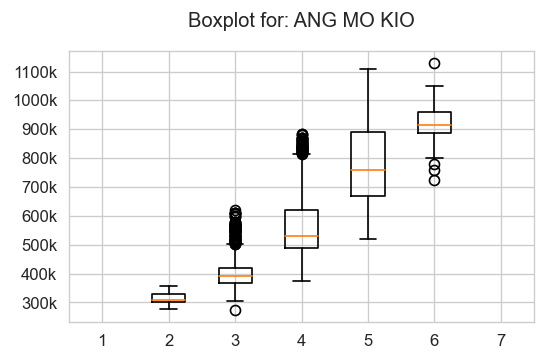

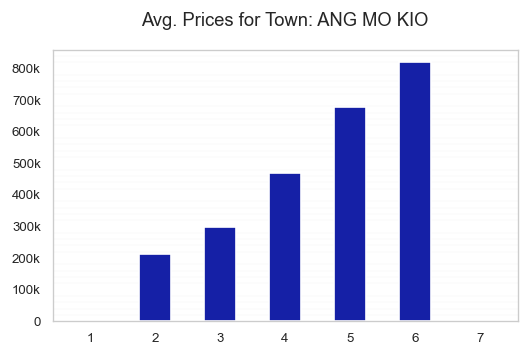

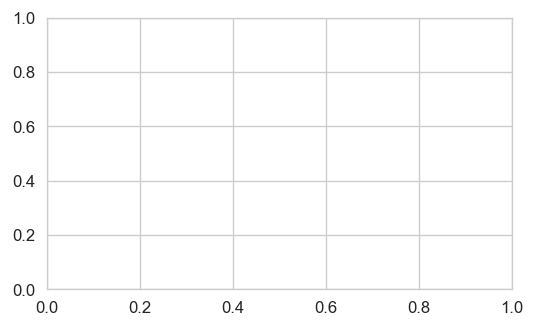

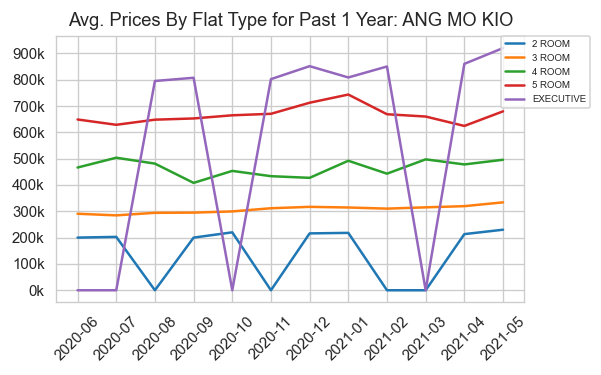

In [92]:
#-------------------------------------------------------------
# Function for setting up a tkinter window 
#-------------------------------------------------------------

def setUpTKinterWindow(winWidth, winHeight):
    # Setting up our tkinter window
    window = tk.Tk()
    window.resizable(width=False, height=False)  # Non resizable
    window.title("Resale Flat Prices")
    posRight = int(window.winfo_screenwidth() / 2 - winWidth / 2)
    posDown = int(window.winfo_screenheight() / 2 - winHeight / 2)
    window.geometry("+{}+{}".format(posRight, posDown))
    window.option_add("*tearoff",False)

    window.tk.call('source', 'Azure-ttk-theme-main/azure-dark.tcl')
    return window


# -------------------------------------------------------------
# Main program
# -------------------------------------------------------------

# Size of our window
winWidth = 900
winHeight = 500


# Set up our tkinter window
window = setUpTKinterWindow(winWidth, winHeight)

# Get our DataManager up
dataManager = DataManager()

# Make sure you downloaded the data file and placed in a folder named data (together were your notebook is)
dataManager.readData(r'resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

# Get our ScreenManager up
screenManager = ScreenManager(window, winWidth, winHeight, dataManager)

# Load the start screen
screenManager.loadScreen('START_SCREEN')


# Run the main loop
window.mainloop()
